<a href="https://colab.research.google.com/github/RonBartov/Deep_Learning_Basics/blob/main/Assignment3_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself.

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.


In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob

# Ron's paths
# train_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Assignment 3/train/*'
# test_w_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Assignment 3/test_w/*'
# test_m_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Assignment 3/test_m/*'

# Aviv's paths
train_file_path = '/content/gdrive/MyDrive/DP_course/ex3/data/train/*'
test_w_file_path = '/content/gdrive/MyDrive/DP_course/ex3/data/test_w/*'
test_m_file_path = '/content/gdrive/MyDrive/DP_course/ex3/data/test_m/*'


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
##### Creating the DATA set as Numpy arrays######
images_train = {}
for file in glob.glob(train_file_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images_train[filename] = img[:, :, :3] # remove the alpha channel

shift_param = 0.5
img_name_list_train = sorted(list(images_train.keys()))
num_of_triplet_train = int((len(img_name_list_train)/6))
train_val_ratio = 2/3
train_size = int(np.floor(num_of_triplet_train*train_val_ratio)) ##floor(113*(2/3)) = floor(75.3) = 75
val_size = int(np.ceil(num_of_triplet_train*(1-train_val_ratio))) ##ceil(113*(1/3)) = ceil(37.6) = 38    ###38+75=113
train_data = np.zeros((train_size , 3,2,224,224,3)) ## [75,3,2,224,224,3]
validation_data = np.zeros((val_size , 3,2,224,224,3)) ## [38,3,2,224,224,3]
#####create train data####
n = 0
for i in range(train_size):
  for j in range(3):
    for k in range(2):
      img = images_train[img_name_list_train[n]]
      train_data[i , j , k , : , :] = (img/(np.max(img))) - shift_param
      n +=1
#####create validation data####
for i in range(val_size):
  for j in range(3):
    for k in range(2):
      img = images_train[img_name_list_train[n]]
      validation_data[i , j , k , : , :] = (img/(np.max(img))) - shift_param
      n +=1


In [ ]:
##### create test_m data ######

images_test_m = {}
for file in glob.glob(test_m_file_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images_test_m[filename] = img[:, :, :3] # remove the alpha channel

img_name_list_test_m = sorted(list(images_test_m.keys()))
num_of_triplet_test_m = int((len(img_name_list_test_m)/6))
test_m = np.zeros((num_of_triplet_test_m , 3,2,224,224,3)) ## [*,3,2,224,224,3]

n = 0
for i in range(num_of_triplet_test_m):
  for j in range(3):
    for k in range(2):
      img = images_test_m[img_name_list_test_m[n]]
      test_m[i , j , k , : , :] = (img/(np.max(img))) - shift_param
      n +=1

In [ ]:
##### create test_w data ######

images_test_w = {}
for file in glob.glob(test_w_file_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images_test_w[filename] = img[:, :, :3] # remove the alpha channel

img_name_list_test_w = sorted(list(images_test_w.keys()))
num_of_triplet_test_w = int((len(img_name_list_test_w)/6))
test_w = np.zeros((num_of_triplet_test_w , 3,2,224,224,3)) ## [*,3,2,224,224,3]

n = 0
for i in range(num_of_triplet_test_w):
  for j in range(3):
    for k in range(2):
      img = images_test_w[img_name_list_test_w[n]]
      test_w[i , j , k , : , :] = (img/(np.max(img))) - shift_param
      n +=1

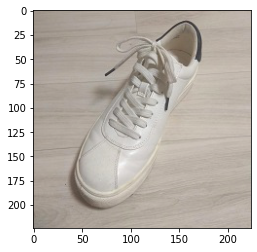

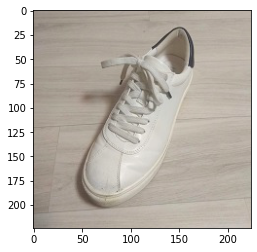

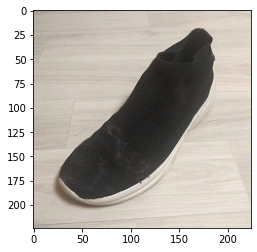

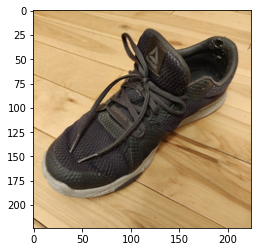

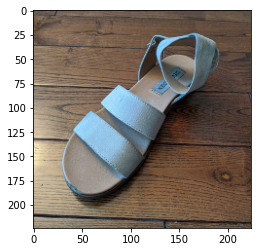

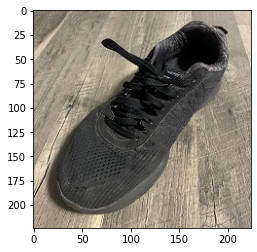

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+shift_param) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+shift_param) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+shift_param) # right shoe of second pair submitted by 5th student
plt.figure()
plt.imshow(validation_data[4,1,1,:,:,:]+shift_param) # right shoe of second pair submitted by 5th student in validation
plt.figure()
plt.imshow(test_w[0,1,1,:,:,:]+shift_param)
plt.figure()
plt.imshow(test_m[0,1,1,:,:,:]+shift_param)

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(75, 3, 2, 224, 224, 3)
(225, 448, 224, 3)


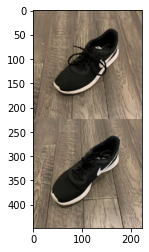

In [ ]:
def generate_same_pair(data_set):
  '''
  param: data_set: np array [X , 3 , 2 , 224 ,224 , 3]
  return: np array [X*3 , 448 ,224 , 3]
  '''
  input_size = data_set.shape[0]
  same_pair_array = np.zeros((input_size*3 ,448 ,224 , 3 ))
  for i in range(input_size):
    for j in range(3):
      same_pair_array[i*3+j , 0:224 , : , :] = data_set[i , j , 0 , : ,: , :]
      same_pair_array[i*3+j , 224:448 , : , :] = data_set[i , j , 1 , : ,: , :]
  return same_pair_array


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+shift_param ) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(75, 3, 2, 224, 224, 3)
(225, 448, 224, 3)


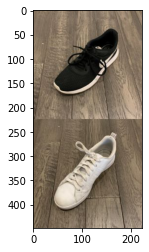

In [ ]:
def generate_different_pair(data_set):
  '''
  param: data_set: np array [X , 3 , 2 , 224 ,224 , 3]
  return: np array [X*3 , 448 ,224 , 3]
  '''
  input_size = data_set.shape[0]
  different_pair_array = np.zeros((input_size*3 ,448 ,224 , 3 ))
  for i in range(input_size):
      different_pair_array[i*3 , 0:224 , : , :] = data_set[i , 0 , 0 , : ,: , :]
      different_pair_array[i*3, 224:448 , : , :] = data_set[i , 1 , 1 , : ,: , :]
      different_pair_array[i*3+1 , 0:224 , : , :] = data_set[i , 1 , 0 , : ,: , :]
      different_pair_array[i*3+1, 224:448 , : , :] = data_set[i , 2 , 1 , : ,: , :]
      different_pair_array[i*3+2 , 0:224 , : , :] = data_set[i , 2 , 0 , : ,: , :]
      different_pair_array[i*3+2, 224:448 , : , :] = data_set[i , 0 , 1 , : ,: , :]
  return different_pair_array

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

The image was taken in the same envoirment , most of the pictured taken by the same person have the same background and same lightning and etc...

This will help the algorithm detect relations between two images and by so make the classification easier

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

It is importent to keep the data set balanced because an imblanced data set can bais the probability to recieve a pair or not because the network will automatically create the weigths so that the larger samples have a larger a-proirity probability.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature = 4  , kernel_size = 5):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size = kernel_size , padding= int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size = kernel_size , padding= int((kernel_size-1)/2))
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature,kernel_size = kernel_size , padding= int((kernel_size-1)/2))
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature,kernel_size = kernel_size , padding= int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear((8*n_feature)*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.reshape(-1, (8*self.n_feature)*28*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n_feature = 4 , kernel_size = 5):
        super(CNNChannel, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n_feature, kernel_size=kernel_size , padding= int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=kernel_size, padding= int((kernel_size-1)/2))
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=kernel_size, padding= int((kernel_size-1)/2))
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear((8*n_feature)*14*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x, verbose=False):
        x = torch.cat((x[: , : , 0:224 , :] , x[: , : , 224: , :]),1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.reshape(-1, (8*self.n_feature)*14*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

First let's analyze the diffrence between each CNN:

The first one recieves an input of two pictures togetheter and makes the convulotion (the kernel) on both of them togother, by so it can only analyze if they are a pair or not.

The second CNN recieves each picture seperatly and does the convulution on each picture seperatly and thus can analyze and detect pairs of shoes and not only if it is a pair or not, by so the CNN Channel has more flexibility and will be able to learn much faster in our opinion.




## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

In [ ]:
def get_accuracy(model, data, batch_size=5):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]


    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).swapaxes(1, 3).swapaxes(2 , 3)
        xs = xs.to(device)
        zs = model(xs).cpu()
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).swapaxes(1, 3).swapaxes(2 , 3)
        xs = xs.to(device)
        zs = model(xs).cpu()
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
def train_model(model , train_data , val_data , batch_size=24 ,learning_rate=0.001, weight_decay=0 , max_iters = 100 , checkpoint_path=None):

  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay =weight_decay )
  iters, losses = [], []
  iters_sub, train_accs_pos , train_accs_neg, val_accs_pos ,val_accs_neg   = [], [] ,[],[],[]
  xt_positive = generate_same_pair(train_data)
  xt_negative = generate_different_pair(train_data)
  val_positive = generate_same_pair(val_data)
  val_negative = generate_different_pair(val_data)
  n = 0 # the number of iterations
  while True:
      for i in range(0, xt_positive.shape[0], int(batch_size/2)):
          if (i + batch_size/2) > xt_positive.shape[0]:
              break

          xt_pos_minibatch = torch.Tensor(xt_positive[i:i+ int((batch_size/2))])
          xt_neg_minibatch = torch.Tensor(xt_negative[i:i+ int((batch_size/2))])
          labels = np.concatenate((np.ones(int(batch_size/2)),np.zeros(int(batch_size/2))))
          labels = torch.Tensor(labels).long() #merge the labels
          labels_one_hot = F.one_hot(labels,2)
          merged_minibatch = torch.cat((xt_pos_minibatch , xt_neg_minibatch),0)
          random_per = np.random.permutation(batch_size)
          merged_minibatch = merged_minibatch[random_per] #shuffle the date
          labels_one_hot = labels_one_hot[random_per] #shuffle the labels accordingly
          labels = labels[random_per]
          merged_minibatch = merged_minibatch.swapaxes(1, 3).swapaxes(2 , 3)
          merged_minibatch = torch.Tensor(merged_minibatch)
          merged_minibatch, labels = merged_minibatch.to(device), labels.to(device)
          optimizer.zero_grad()
          prediction = model(merged_minibatch)
          loss = criterion(prediction , labels)
          loss.backward()
          optimizer.step()
          iters.append(n)
          losses.append(float(loss.cpu())/batch_size)  # compute *average* loss

          if n % 10 == 0:
            iters_sub.append(n)
            train_cost = float(loss.detach().cpu().numpy())
            train_acc_positive ,train_acc_negative = get_accuracy(model, train_data , batch_size=batch_size)
            train_accs_pos.append(train_acc_positive)
            train_accs_neg.append(train_acc_negative)
            val_acc_positive ,val_acc_negative  = get_accuracy(model, validation_data,batch_size=batch_size)
            val_accs_pos.append(val_acc_positive)
            val_accs_neg.append(val_acc_negative)
            print("Iter %d. [Val Acc Positive %.0f%%,Val Acc Negative %.0f%%] [Train Acc Positive %.0f%%,Train Acc Negative %.0f%% , Loss %f]" % (
                   n, val_acc_positive * 100,val_acc_negative*100 ,train_acc_positive * 100 ,train_acc_negative * 100 , train_cost))

            if (checkpoint_path is not None) and n > 0:
                torch.save(model.state_dict(), checkpoint_path.format(n))

          n += 1
          if n > max_iters:
                return iters, losses, iters_sub, train_accs_pos , train_accs_neg, val_accs_pos ,val_accs_neg


### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
model_cnn = CNN(n_feature = 4)
model_cnn.to(device)
learning_curve_info_sanity_1 = train_model(model = model_cnn , train_data= train_data[0:1] , learning_rate = 0.0005, val_data=validation_data , max_iters = 80 , batch_size = 6)

###done

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.695456]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693112]
Iter 20. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.692874]
Iter 30. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.692213]
Iter 40. [Val Acc Positive 12%,Val Acc Negative 88%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.689687]
Iter 50. [Val Acc Positive 5%,Val Acc Negative 97%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.678239]
Iter 60. [Val Acc Positive 7%,Val Acc Negative 95%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.657371]
Iter 70. [Val Acc Positive 80%,Val Acc Negative 24%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.567449]
Iter 80. [Val Acc Positive 49%,Val Acc Negative 58%] [Train A

In [ ]:
model_cnn = CNNChannel(n_feature = 4)
model_cnn.to(device)
learning_curve_info_sanity_2 = train_model(model = model_cnn , train_data= train_data[0:1] , learning_rate = 0.001, val_data=validation_data , max_iters = 50 , batch_size = 6)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.694473]
Iter 10. [Val Acc Positive 95%,Val Acc Negative 36%] [Train Acc Positive 100%,Train Acc Negative 67% , Loss 0.546956]
Iter 20. [Val Acc Positive 91%,Val Acc Negative 46%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.000185]
Iter 30. [Val Acc Positive 86%,Val Acc Negative 50%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.000000]
Iter 40. [Val Acc Positive 84%,Val Acc Negative 50%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.000000]
Iter 50. [Val Acc Positive 83%,Val Acc Negative 51%] [Train Acc Positive 100%,Train Acc Negative 100% , Loss 0.000000]


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

In [ ]:
##### change only the kernel size ####
model_cnn_1 = CNN(n_feature = 4 , kernel_size = 3)
model_cnn_1.to(device)
learning_curve_info_cnn_kernel_3 = train_model(model = model_cnn_1 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)


Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693191]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693432]
Iter 20. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693158]
Iter 30. [Val Acc Positive 55%,Val Acc Negative 46%] [Train Acc Positive 57%,Train Acc Negative 42% , Loss 0.693153]
Iter 40. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693150]
Iter 50. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693145]
Iter 60. [Val Acc Positive 99%,Val Acc Negative 3%] [Train Acc Positive 96%,Train Acc Negative 5% , Loss 0.693137]
Iter 70. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693142]
Iter 80. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Pos

In [ ]:
##### change only the kernel size ####
model_cnn_2 = CNN(n_feature = 4 , kernel_size = 5)
model_cnn_2.to(device)
learning_curve_info_cnn_kernel_5= train_model(model = model_cnn_2 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693693]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693419]
Iter 20. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693169]
Iter 30. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693150]
Iter 40. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693147]
Iter 50. [Val Acc Positive 72%,Val Acc Negative 25%] [Train Acc Positive 66%,Train Acc Negative 32% , Loss 0.693146]
Iter 60. [Val Acc Positive 61%,Val Acc Negative 40%] [Train Acc Positive 51%,Train Acc Negative 48% , Loss 0.693147]
Iter 70. [Val Acc Positive 59%,Val Acc Negative 46%] [Train Acc Positive 53%,Train Acc Negative 47% , Loss 0.693146]
Iter 80. [Val Acc Positive 46%,Val Acc Negative 55%] [Train Acc P

In [ ]:
##### change only the kernel size ####
model_cnn_3 = CNN(n_feature = 4 , kernel_size = 7)
model_cnn_3.to(device)
learning_curve_info_cnn_1_kernel_9 = train_model(model = model_cnn_3 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693890]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693194]
Iter 20. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693134]
Iter 30. [Val Acc Positive 94%,Val Acc Negative 5%] [Train Acc Positive 96%,Train Acc Negative 3% , Loss 0.693156]
Iter 40. [Val Acc Positive 98%,Val Acc Negative 3%] [Train Acc Positive 99%,Train Acc Negative 0% , Loss 0.693121]
Iter 50. [Val Acc Positive 82%,Val Acc Negative 18%] [Train Acc Positive 82%,Train Acc Negative 15% , Loss 0.693139]
Iter 60. [Val Acc Positive 57%,Val Acc Negative 46%] [Train Acc Positive 56%,Train Acc Negative 52% , Loss 0.693103]
Iter 70. [Val Acc Positive 69%,Val Acc Negative 32%] [Train Acc Positive 64%,Train Acc Negative 42% , Loss 0.692376]
Iter 80. [Val Acc Positive 86%,Val Acc Negative 18%] [Train Acc Posit

In [ ]:
#### change only n_feature ####
model_cnn_4 = CNN(n_feature = 6 , kernel_size = 7)
model_cnn_4.to(device)
learning_curve_info_cnn_1 = train_model(model = model_cnn_4 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693164]
Iter 10. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693169]
Iter 20. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693125]
Iter 30. [Val Acc Positive 21%,Val Acc Negative 87%] [Train Acc Positive 26%,Train Acc Negative 89% , Loss 0.692850]
Iter 40. [Val Acc Positive 89%,Val Acc Negative 32%] [Train Acc Positive 95%,Train Acc Negative 41% , Loss 0.650454]
Iter 50. [Val Acc Positive 40%,Val Acc Negative 73%] [Train Acc Positive 44%,Train Acc Negative 74% , Loss 0.687904]
Iter 60. [Val Acc Positive 61%,Val Acc Negative 63%] [Train Acc Positive 61%,Train Acc Negative 73% , Loss 0.642150]
Iter 70. [Val Acc Positive 88%,Val Acc Negative 53%] [Train Acc Positive 87%,Train Acc Negative 64% , Loss 0.452104]
Iter 80. [Val Acc Positive 84%,Val Acc Negative 62%] [Train Acc P

In [ ]:
#### change only n_feature ####
model_cnn_5 = CNN(n_feature = 10 , kernel_size = 7)
model_cnn_5.to(device)
learning_curve_info_cnn_2 = train_model(model = model_cnn_5 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693534]
Iter 10. [Val Acc Positive 96%,Val Acc Negative 2%] [Train Acc Positive 95%,Train Acc Negative 2% , Loss 0.693310]
Iter 20. [Val Acc Positive 35%,Val Acc Negative 64%] [Train Acc Positive 40%,Train Acc Negative 61% , Loss 0.693136]
Iter 30. [Val Acc Positive 61%,Val Acc Negative 43%] [Train Acc Positive 56%,Train Acc Negative 50% , Loss 0.693092]
Iter 40. [Val Acc Positive 80%,Val Acc Negative 24%] [Train Acc Positive 83%,Train Acc Negative 21% , Loss 0.693009]
Iter 50. [Val Acc Positive 24%,Val Acc Negative 78%] [Train Acc Positive 19%,Train Acc Negative 84% , Loss 0.693182]
Iter 60. [Val Acc Positive 55%,Val Acc Negative 72%] [Train Acc Positive 48%,Train Acc Negative 74% , Loss 0.681931]
Iter 70. [Val Acc Positive 37%,Val Acc Negative 75%] [Train Acc Positive 42%,Train Acc Negative 77% , Loss 0.615131]
Iter 80. [Val Acc Positive 29%,Val Acc Negative 88%] [Train Acc Pos

In [ ]:
#### change only n_feature ####
model_cnn_6 = CNN(n_feature = 14 , kernel_size = 7)
model_cnn_6.to(device)
learning_curve_info_cnn_3 = train_model(model = model_cnn_6 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693620]
Iter 10. [Val Acc Positive 25%,Val Acc Negative 75%] [Train Acc Positive 24%,Train Acc Negative 78% , Loss 0.693409]
Iter 20. [Val Acc Positive 54%,Val Acc Negative 47%] [Train Acc Positive 50%,Train Acc Negative 49% , Loss 0.693201]
Iter 30. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693186]
Iter 40. [Val Acc Positive 10%,Val Acc Negative 92%] [Train Acc Positive 13%,Train Acc Negative 88% , Loss 0.693063]
Iter 50. [Val Acc Positive 50%,Val Acc Negative 47%] [Train Acc Positive 55%,Train Acc Negative 45% , Loss 0.693066]
Iter 60. [Val Acc Positive 12%,Val Acc Negative 89%] [Train Acc Positive 11%,Train Acc Negative 90% , Loss 0.693096]
Iter 70. [Val Acc Positive 50%,Val Acc Negative 54%] [Train Acc Positive 53%,Train Acc Negative 51% , Loss 0.691873]
Iter 80. [Val Acc Positive 16%,Val Acc Negative 88%] [Train Acc P

In [ ]:
#### change only learning rate ####
model_cnn_7 = CNN(n_feature = 10 , kernel_size = 7)
model_cnn_7.to(device)
learning_curve_info_cnn_4 = train_model(model = model_cnn_7 , train_data= train_data,learning_rate=0.0001 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.695285]
Iter 10. [Val Acc Positive 96%,Val Acc Negative 3%] [Train Acc Positive 97%,Train Acc Negative 3% , Loss 0.693266]
Iter 20. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693149]
Iter 30. [Val Acc Positive 11%,Val Acc Negative 92%] [Train Acc Positive 14%,Train Acc Negative 90% , Loss 0.693100]
Iter 40. [Val Acc Positive 19%,Val Acc Negative 86%] [Train Acc Positive 19%,Train Acc Negative 84% , Loss 0.692532]
Iter 50. [Val Acc Positive 83%,Val Acc Negative 28%] [Train Acc Positive 84%,Train Acc Negative 24% , Loss 0.691801]
Iter 60. [Val Acc Positive 67%,Val Acc Negative 46%] [Train Acc Positive 70%,Train Acc Negative 40% , Loss 0.683911]
Iter 70. [Val Acc Positive 77%,Val Acc Negative 36%] [Train Acc Positive 80%,Train Acc Negative 34% , Loss 0.678162]
Iter 80. [Val Acc Positive 74%,Val Acc Negative 43%] [Train Acc Pos

In [ ]:
#### change only learning rate ####
model_cnn_8 = CNN(n_feature = 10 , kernel_size = 7)
model_cnn_8.to(device)
learning_curve_info_cnn_5 = train_model(model = model_cnn_8 , train_data= train_data,learning_rate=0.007 , val_data=validation_data , max_iters = 400 , batch_size = 24)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693211]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.701063]
Iter 20. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693242]
Iter 30. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693406]
Iter 40. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693204]
Iter 50. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693148]
Iter 60. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693150]
Iter 70. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693150]
Iter 80. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc P

In [ ]:
#### change only batch size ####
model_cnn_9 = CNN(n_feature = 10 , kernel_size = 7)
model_cnn_9.to(device)
learning_curve_info_cnn_6 = train_model(model = model_cnn_9 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 10)

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693869]
Iter 10. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693178]
Iter 20. [Val Acc Positive 96%,Val Acc Negative 5%] [Train Acc Positive 99%,Train Acc Negative 1% , Loss 0.693149]
Iter 30. [Val Acc Positive 48%,Val Acc Negative 54%] [Train Acc Positive 53%,Train Acc Negative 51% , Loss 0.693066]
Iter 40. [Val Acc Positive 14%,Val Acc Negative 87%] [Train Acc Positive 13%,Train Acc Negative 88% , Loss 0.692985]
Iter 50. [Val Acc Positive 33%,Val Acc Negative 69%] [Train Acc Positive 35%,Train Acc Negative 71% , Loss 0.693250]
Iter 60. [Val Acc Positive 4%,Val Acc Negative 97%] [Train Acc Positive 4%,Train Acc Negative 95% , Loss 0.689299]
Iter 70. [Val Acc Positive 78%,Val Acc Negative 32%] [Train Acc Positive 76%,Train Acc Negative 35% , Loss 0.687902]
Iter 80. [Val Acc Positive 88%,Val Acc Negative 20%] [Train Acc Posit

In [ ]:
#### change only batch size ####
model_cnn_10 = CNN(n_feature = 10 , kernel_size = 7)
model_cnn_10.to(device)
learning_curve_info_cnn_7 = train_model(model = model_cnn_10 , train_data= train_data,learning_rate=0.001 , val_data=validation_data , max_iters = 400 , batch_size = 48)

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.696167]
Iter 10. [Val Acc Positive 89%,Val Acc Negative 6%] [Train Acc Positive 87%,Train Acc Negative 12% , Loss 0.693190]
Iter 20. [Val Acc Positive 48%,Val Acc Negative 53%] [Train Acc Positive 64%,Train Acc Negative 36% , Loss 0.693125]
Iter 30. [Val Acc Positive 44%,Val Acc Negative 58%] [Train Acc Positive 56%,Train Acc Negative 44% , Loss 0.693135]
Iter 40. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693181]
Iter 50. [Val Acc Positive 46%,Val Acc Negative 52%] [Train Acc Positive 51%,Train Acc Negative 52% , Loss 0.693067]
Iter 60. [Val Acc Positive 37%,Val Acc Negative 75%] [Train Acc Positive 43%,Train Acc Negative 64% , Loss 0.692807]
Iter 70. [Val Acc Positive 42%,Val Acc Negative 68%] [Train Acc Positive 49%,Train Acc Negative 60% , Loss 0.691665]
Iter 80. [Val Acc Positive 65%,Val Acc Negative 45%] [Train Acc Po

In [ ]:
#### CNNChannel ########
model_cnn_channel_1 = CNNChannel(n_feature = 4 , kernel_size = 5)
model_cnn_channel_1.to(device)
learning_curve_info_cnn_channel_1 = train_model(model = model_cnn_channel_1 , train_data= train_data,learning_rate=0.0005 , val_data=validation_data , max_iters = 400 , batch_size = 24 )


Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.695200]
Iter 10. [Val Acc Positive 42%,Val Acc Negative 68%] [Train Acc Positive 46%,Train Acc Negative 69% , Loss 0.689850]
Iter 20. [Val Acc Positive 83%,Val Acc Negative 54%] [Train Acc Positive 80%,Train Acc Negative 56% , Loss 0.672431]
Iter 30. [Val Acc Positive 88%,Val Acc Negative 66%] [Train Acc Positive 90%,Train Acc Negative 63% , Loss 0.519824]
Iter 40. [Val Acc Positive 91%,Val Acc Negative 74%] [Train Acc Positive 88%,Train Acc Negative 68% , Loss 0.399329]
Iter 50. [Val Acc Positive 88%,Val Acc Negative 77%] [Train Acc Positive 86%,Train Acc Negative 77% , Loss 0.261723]
Iter 60. [Val Acc Positive 82%,Val Acc Negative 84%] [Train Acc Positive 85%,Train Acc Negative 84% , Loss 0.381920]
Iter 70. [Val Acc Positive 86%,Val Acc Negative 82%] [Train Acc Positive 87%,Train Acc Negative 81% , Loss 0.380247]
Iter 80. [Val Acc Positive 88%,Val Acc Negative 81%] [Train Acc P

In [ ]:
#### CNNChannel ########
##### change only kernel_size #####
model_cnn_channel_1 = CNNChannel(n_feature = 4 , kernel_size = 3)
model_cnn_channel_1.to(device)
learning_curve_info_cnn_channel_2 = train_model(model = model_cnn_channel_1 , train_data= train_data,learning_rate=0.0005 , val_data=validation_data , max_iters = 400 , batch_size = 24 ,
                                                checkpoint_path='/content/gdrive/MyDrive/DP_course/ex3/mlp/ckpt-{}.pk')


Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693342]
Iter 10. [Val Acc Positive 68%,Val Acc Negative 49%] [Train Acc Positive 74%,Train Acc Negative 53% , Loss 0.693032]
Iter 20. [Val Acc Positive 77%,Val Acc Negative 49%] [Train Acc Positive 76%,Train Acc Negative 55% , Loss 0.691085]
Iter 30. [Val Acc Positive 68%,Val Acc Negative 74%] [Train Acc Positive 65%,Train Acc Negative 69% , Loss 0.669435]
Iter 40. [Val Acc Positive 81%,Val Acc Negative 63%] [Train Acc Positive 80%,Train Acc Negative 66% , Loss 0.586858]
Iter 50. [Val Acc Positive 83%,Val Acc Negative 67%] [Train Acc Positive 83%,Train Acc Negative 69% , Loss 0.433160]
Iter 60. [Val Acc Positive 68%,Val Acc Negative 86%] [Train Acc Positive 67%,Train Acc Negative 84% , Loss 0.483148]
Iter 70. [Val Acc Positive 82%,Val Acc Negative 79%] [Train Acc Positive 81%,Train Acc Negative 77% , Loss 0.379598]
Iter 80. [Val Acc Positive 84%,Val Acc Negative 79%] [Train Acc P

In [ ]:
#### CNNChannel ########
##### change only n_feature #####
model_cnn_channel_3 = CNNChannel(n_feature =  2, kernel_size = 3)
model_cnn_channel_3.to(device)
learning_curve_info_cnn_channel_3 = train_model(model = model_cnn_channel_3 , train_data= train_data,learning_rate=0.0005 , val_data=validation_data ,
                                                max_iters = 400 , batch_size = 24 ,checkpoint_path='/content/gdrive/MyDrive/DP_course/ex3/mlp2/ckpt-{}.pk')

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693439]
Iter 10. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693094]
Iter 20. [Val Acc Positive 21%,Val Acc Negative 88%] [Train Acc Positive 30%,Train Acc Negative 87% , Loss 0.691271]
Iter 30. [Val Acc Positive 73%,Val Acc Negative 60%] [Train Acc Positive 74%,Train Acc Negative 59% , Loss 0.682798]
Iter 40. [Val Acc Positive 91%,Val Acc Negative 44%] [Train Acc Positive 89%,Train Acc Negative 42% , Loss 0.654646]
Iter 50. [Val Acc Positive 94%,Val Acc Negative 46%] [Train Acc Positive 90%,Train Acc Negative 44% , Loss 0.588151]
Iter 60. [Val Acc Positive 84%,Val Acc Negative 59%] [Train Acc Positive 84%,Train Acc Negative 57% , Loss 0.570508]
Iter 70. [Val Acc Positive 95%,Val Acc Negative 45%] [Train Acc Positive 93%,Train Acc Negative 46% , Loss 0.519537]
Iter 80. [Val Acc Positive 73%,Val Acc Negative 74%] [Train Acc P

In [ ]:
#### CNNChannel ########
##### change only n_feature #####
model_cnn_channel_4 = CNNChannel(n_feature =  8, kernel_size = 3)
model_cnn_channel_4.to(device)
learning_curve_info_cnn_channel_4 = train_model(model = model_cnn_channel_4 , train_data= train_data,learning_rate=0.0005 , val_data=validation_data , max_iters = 400 , batch_size = 24 )

Iter 0. [Val Acc Positive 0%,Val Acc Negative 100%] [Train Acc Positive 0%,Train Acc Negative 100% , Loss 0.693840]
Iter 10. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693306]
Iter 20. [Val Acc Positive 85%,Val Acc Negative 29%] [Train Acc Positive 70%,Train Acc Negative 44% , Loss 0.691603]
Iter 30. [Val Acc Positive 70%,Val Acc Negative 48%] [Train Acc Positive 61%,Train Acc Negative 65% , Loss 0.680255]
Iter 40. [Val Acc Positive 89%,Val Acc Negative 49%] [Train Acc Positive 84%,Train Acc Negative 59% , Loss 0.600383]
Iter 50. [Val Acc Positive 92%,Val Acc Negative 59%] [Train Acc Positive 91%,Train Acc Negative 63% , Loss 0.432704]
Iter 60. [Val Acc Positive 78%,Val Acc Negative 75%] [Train Acc Positive 76%,Train Acc Negative 81% , Loss 0.483957]
Iter 70. [Val Acc Positive 93%,Val Acc Negative 61%] [Train Acc Positive 94%,Train Acc Negative 64% , Loss 0.391682]
Iter 80. [Val Acc Positive 89%,Val Acc Negative 72%] [Train Acc P

In [ ]:
#### CNNChannel ########
##### change only learning rate #####
model_cnn_channel_5 = CNNChannel(n_feature =  4, kernel_size = 3)
model_cnn_channel_5.to(device)
learning_curve_info_cnn_channel_5 = train_model(model = model_cnn_channel_5 , train_data= train_data,learning_rate=0.002 , val_data=validation_data , max_iters = 400 , batch_size = 24 )

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.694765]
Iter 10. [Val Acc Positive 100%,Val Acc Negative 1%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.692529]
Iter 20. [Val Acc Positive 71%,Val Acc Negative 72%] [Train Acc Positive 74%,Train Acc Negative 66% , Loss 0.656348]
Iter 30. [Val Acc Positive 28%,Val Acc Negative 93%] [Train Acc Positive 43%,Train Acc Negative 90% , Loss 0.472305]
Iter 40. [Val Acc Positive 48%,Val Acc Negative 89%] [Train Acc Positive 52%,Train Acc Negative 87% , Loss 0.597427]
Iter 50. [Val Acc Positive 96%,Val Acc Negative 50%] [Train Acc Positive 97%,Train Acc Negative 56% , Loss 0.315186]
Iter 60. [Val Acc Positive 71%,Val Acc Negative 85%] [Train Acc Positive 76%,Train Acc Negative 86% , Loss 0.413966]
Iter 70. [Val Acc Positive 96%,Val Acc Negative 54%] [Train Acc Positive 98%,Train Acc Negative 64% , Loss 0.374705]
Iter 80. [Val Acc Positive 91%,Val Acc Negative 77%] [Train Acc P

In [ ]:
#### CNNChannel ########
##### change only learning rate #####
model_cnn_channel_6 = CNNChannel(n_feature =  4, kernel_size = 3)
model_cnn_channel_6.to(device)
learning_curve_info_cnn_channel_6 = train_model(model = model_cnn_channel_6 , train_data= train_data,learning_rate=0.008 , val_data=validation_data , max_iters = 400 , batch_size = 24 )

Iter 0. [Val Acc Positive 100%,Val Acc Negative 0%] [Train Acc Positive 100%,Train Acc Negative 0% , Loss 0.693970]
Iter 10. [Val Acc Positive 3%,Val Acc Negative 99%] [Train Acc Positive 4%,Train Acc Negative 100% , Loss 0.689467]
Iter 20. [Val Acc Positive 15%,Val Acc Negative 94%] [Train Acc Positive 16%,Train Acc Negative 94% , Loss 0.680957]
Iter 30. [Val Acc Positive 5%,Val Acc Negative 96%] [Train Acc Positive 4%,Train Acc Negative 98% , Loss 0.695268]
Iter 40. [Val Acc Positive 85%,Val Acc Negative 21%] [Train Acc Positive 82%,Train Acc Negative 29% , Loss 0.679915]
Iter 50. [Val Acc Positive 96%,Val Acc Negative 9%] [Train Acc Positive 94%,Train Acc Negative 11% , Loss 0.647915]
Iter 60. [Val Acc Positive 43%,Val Acc Negative 65%] [Train Acc Positive 46%,Train Acc Negative 69% , Loss 0.691305]
Iter 70. [Val Acc Positive 47%,Val Acc Negative 64%] [Train Acc Positive 48%,Train Acc Negative 71% , Loss 0.732929]
Iter 80. [Val Acc Positive 15%,Val Acc Negative 95%] [Train Acc Posit

In [ ]:
def plot_learning_curve(iters, losses, iters_sub, train_accs_pos , train_accs_neg, val_accs_pos ,val_accs_neg ):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs_pos, label="Train Positive")
    plt.plot(iters_sub, train_accs_neg, label="Train Negative")
    plt.plot(iters_sub, val_accs_pos, label="Validation Positive")
    plt.plot(iters_sub, val_accs_neg, label="Validation Negative")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

**Write your explanation here:**

We tuned our Hypereparamters by conducting a series of tests.
Each test we changed only one hyperparamter and found the best results.
Using the parameter we found in the last test we moved to the next hyperparamter with the one we chose in the previus test.
With this method we changed only one variable at a time, which makes it easier to distinguish the effect of each change in hyperparameter.

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

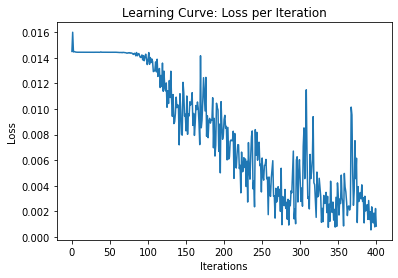

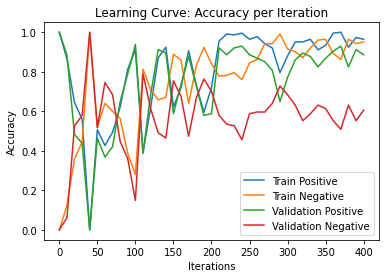

In [ ]:
plot_learning_curve(*learning_curve_info_cnn_7)


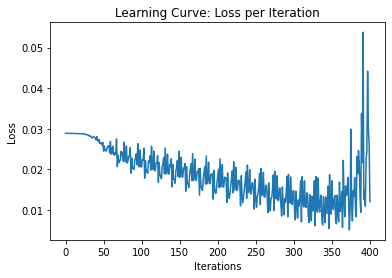

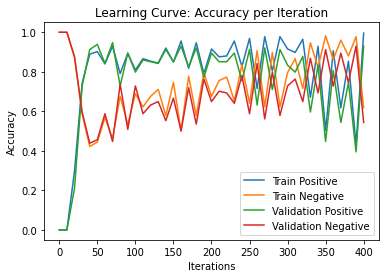

In [ ]:
plot_learning_curve(*learning_curve_info_cnn_channel_3)


## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
cnn_test_accuracy = CNNChannel(n_feature =  4, kernel_size = 3)
cnn_test_accuracy.to(device)
cnn_test_accuracy.load_state_dict(torch.load('/content/gdrive/MyDrive/DP_course/ex3/mlp/ckpt-360.pk'))
test_m_pos,test_m_neg = get_accuracy(cnn_test_accuracy , test_m)
test_w_pos,test_w_neg = get_accuracy(cnn_test_accuracy , test_w)
print(f"Test_m positive accuracy: {test_m_pos*100}%\n Test_m negative accuracy: {test_m_neg*100}%\n")
print(f"Test_w positive accuracy: {test_w_pos*100}%\n Test_w negative accuracy: {test_w_neg*100}%")

Test_m positive accuracy: 86.66666666666667%
 Test_m negative accuracy: 73.33333333333333%

Test_w positive accuracy: 90.0%
 Test_w negative accuracy: 73.33333333333333%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

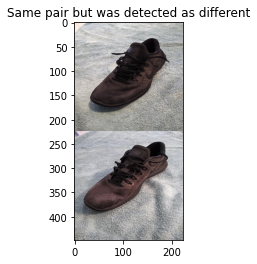

In [ ]:
test_m_positive = torch.Tensor(generate_same_pair(test_m)).swapaxes(1, 3).swapaxes(2 , 3)
test_m_positive = test_m_positive.to(device)
zs = cnn_test_accuracy(test_m_positive).cpu()
pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
pred = pred.detach().numpy()
for i in range(30):
  if pred[i] == 0:
    false_pred = i
    break
  else:
    continue
fig = plt.figure()
plt.title('Same pair but was detected as different')
plt.imshow(generate_same_pair(test_m)[i]+0.5)


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

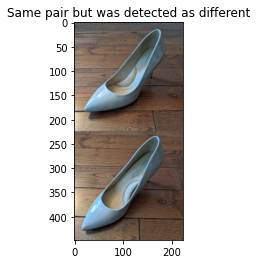

In [ ]:
test_w_positive = torch.Tensor(generate_same_pair(test_w)).swapaxes(1, 3).swapaxes(2 , 3)
test_w_positive = test_w_positive.to(device)
zs = cnn_test_accuracy(test_w_positive).cpu()
pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
pred = pred.detach().numpy()
for i in range(30):
  if pred[i] == 1:
    false_pred = i
    break
  else:
    continue
fig = plt.figure()
plt.title('Same pair but was detected as different')
plt.imshow(generate_same_pair(test_w)[i]+0.5)